/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


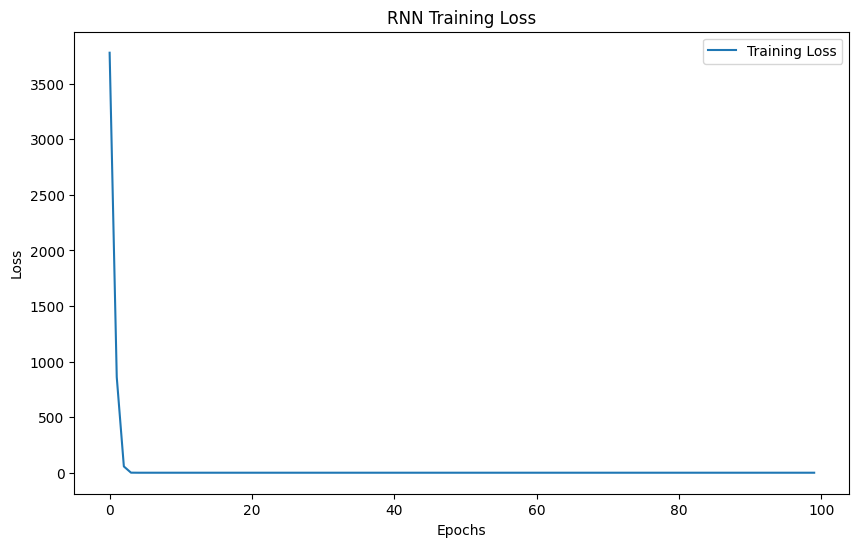

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


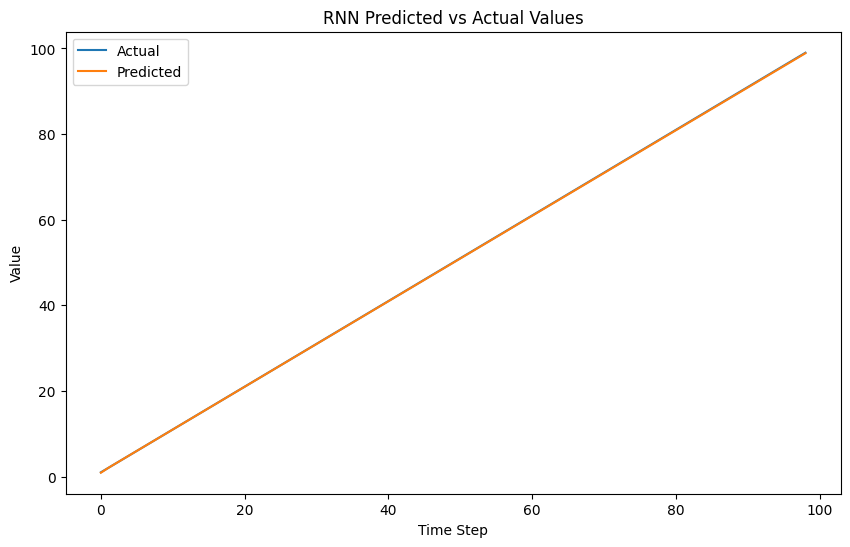

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


# Sample Sequential Data (e.g., time-series or text)
data = np.array([i for i in range(100)])


# Prepare Data
X = data[:-1]  # All except last element
y = data[1:]   # All except first element


X = X.reshape((X.shape[0], 1, 1))  # Reshape for RNN input (batch, time_steps, features)


# Define the RNN Model
model = Sequential([
   SimpleRNN(64, input_shape=(1, 1), activation='relu', return_sequences=False),
   Dense(1)
])


model.compile(optimizer=Adam(), loss='mean_squared_error')


# Train the Model
history = model.fit(X, y, epochs=100, batch_size=1, verbose=0)


# Plotting the Training Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('RNN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Predict
predictions = model.predict(X)


# Plotting Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('RNN Predicted vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Load and preprocess text data


def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text


def preprocess_text(text):
    # Create a mapping from characters to integers and vice versa
    chars = sorted(list(set(text)))
    char2idx = {c: i for i, c in enumerate(chars)}
    idx2char = {i: c for i, c in enumerate(chars)}
    return chars, char2idx, idx2char

# Step 2: Define the dataset


class TextDataset(Dataset):
    def __init__(self, text, char2idx, seq_length):
        self.text = text
        self.char2idx = char2idx
        self.seq_length = seq_length
        self.data = [char2idx[c] for c in text]

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx + self.seq_length]
        target_seq = self.data[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

# Step 3: Define the RNN-based generative model


class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMGenerator, self).__init__()

        # vocab size - number of unique meanings / words.
        # Embed Size - dimension of embedding per word
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device),
                torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device))

# Step 4: Training function
def train_model(model, dataset, batch_size, epochs, lr, char2idx):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)  # Dynamically determine the batch size
            # Reinitialize hidden state for each batch
            hidden = model.init_hidden(batch_size)

            optimizer.zero_grad()
            # Detach hidden states to prevent backprop through time
            hidden = tuple([h.detach() for h in hidden])
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.view(-1, len(char2idx)), targets.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(
            f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

    print("Training complete!")
    return model


# Step 5: Generate sequences using the trained model

def generate_sequence(model, start_text, char2idx, idx2char, seq_length, gen_length):
    model.eval()

    # Ensure all characters in the start_text are in the char2idx vocabulary
    start_text = ''.join([c if c in char2idx else '' for c in start_text])
    if not start_text:
        raise ValueError(
            "The start_text does not contain any valid characters from the training vocabulary.")

    input_seq = torch.tensor(
        [char2idx[c] for c in start_text], dtype=torch.long
    ).unsqueeze(0).to(device)
    hidden = model.init_hidden(1)
    generated_text = start_text

    for _ in range(gen_length):
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)
            probs = torch.softmax(output[0, -1], dim=0).cpu().numpy()
            char_idx = np.random.choice(len(idx2char), p=probs)
            generated_text += idx2char[char_idx]
            input_seq = torch.tensor([[char_idx]], dtype=torch.long).to(device)

    return generated_text
# Load the text file
text_file = "/content/chat_msg.txt"  # Replace with your text file path
text = load_text(text_file)

# Preprocess the text
seq_length = 100  # Sequence length for training
chars, char2idx, idx2char = preprocess_text(text)

# Create dataset
dataset = TextDataset(text, char2idx, seq_length)

# Model parameters
vocab_size = len(chars)
embed_size = 128
hidden_size = 256
num_layers = 2
batch_size = 64
epochs = 20
lr = 0.001

# Initialize and train the model
model = LSTMGenerator(vocab_size, embed_size,
                        hidden_size, num_layers).to(device)
model = train_model(model, dataset, batch_size,epochs, lr, char2idx)

# Generate new sequences
start_text = "Once upon a time"  # Provide a starting text for generation
gen_length = 200  # Number of characters to generate
generated_text = generate_sequence(
    model, start_text, char2idx, idx2char, seq_length, gen_length)
print("\nGenerated Text:")
print(generated_text)

Using device: cpu
Epoch 1/20, Loss: 1.6269
